## Variational Autoencoder (VAE) with PyTorch — CelebA

This repository implements a **Variational Autoencoder (VAE)** using **PyTorch**, inspired by the referenced [Kaggle project](https://www.kaggle.com/code/asheniranga/variational-autoencoder-with-pytorch), with the goal of learning a smooth latent representation of images and generating new, realistic samples. Unlike quantized or deterministic autoencoders, the VAE framework enforces a probabilistic latent space, enabling continuous interpolation and more coherent sample generation.

The model is trained on the **CelebA dataset**, a large-scale face attributes dataset commonly used for generative modeling research. By leveraging an encoder–decoder architecture with a variational bottleneck, this project focuses on understanding latent space regularization, reconstruction quality, and sample diversity in image generation tasks.

The following sections document the implementation step by step, with explanations accompanying each code block.

### 🔧 Utilities and Helper Functions (`utils.py`)

Imports the required libraries for model definition, training, visualization, and experiment management. Two utility functions are defined:

- `checkpointer`: Saves the model and optimizer state whenever a new best score is achieved during training, enabling recovery of the best-performing model.
- `plot_samples`: Plots input images alongside their reconstructed outputs from the VAE, providing a qualitative assessment of reconstruction quality across training epochs. The function supports both grayscale and multi-channel images and can optionally return the figure for saving.

In [11]:
import torch
import os
import torch.nn as nn
import matplotlib.pyplot as plt
from torch import nn
from torchsummary import summary
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from utils import *
from warnings import filterwarnings
filterwarnings(action='ignore')

DATASET_DIR = "./workdir/celebA_dataset/img_align_celeba"
CHKPOINT_DIR = "./workdir/output"
if not os.path.exists(CHKPOINT_DIR):
    os.makedirs(CHKPOINT_DIR)
                
NUM_EPOCHS = 3

LIM_NUM_IMGS = 2000 # total number is more then 202,599
IMG_SIZE = (64, 64) 
BATCH_SIZE = 64
IN_CHANNELS = 3
NUM_EMBEDDINGS = 256 
KERNEL_SIZE = 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Device assigned:", DEVICE)

Device assigned: cuda


### 🔁 Running a Training or Validation Epoch (`run_epoch`)

Defines a unified routine for executing a single training or evaluation epoch. The function iterates over the data loader, performs a forward pass through the VAE, computes the reconstruction loss and KL divergence, and updates model parameters when in training mode.

During validation, selected reconstructions can be visualized and saved for qualitative monitoring. The function tracks and aggregates total loss, reconstruction loss, and KL loss, logs these metrics for later analysis, and optionally computes additional evaluation scores. Checkpointing is triggered automatically when a new best validation score is achieved. The total runtime of the epoch is returned for performance tracking.

### 🏋️ Full Training Loop (`train_loop`)

Implements the complete training workflow for the Variational Autoencoder, coordinating training, validation, and optional testing across multiple epochs. The function manages optimizer initialization, device placement, metric tracking, and learning rate scheduling, while delegating per-epoch computation to the `run_epoch` routine.

Throughout training, it logs reconstruction and KL losses, tracks runtime and learning rate evolution, performs checkpointing for both the best and final models, and optionally visualizes validation reconstructions. All collected metrics are returned as a pandas DataFrame for convenient analysis and plotting.

### 🗂️ Dataset Preparation and Data Loading (`SingleFolderDataset`)

Defines the data preprocessing pipeline and a custom dataset class for loading images from a single folder. Images are resized and converted to tensors before being split into training and test subsets. PyTorch `DataLoader`s are then created to efficiently batch and shuffle the data during training and evaluation. Finally, the appropriate computation device (CUDA, MPS, or CPU) is automatically selected based on availability.

In [12]:
data_transform = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor()])
kwargs = {'num_workers': 0, 'pin_memory': torch.cuda.is_available() and not torch.backends.mps.is_available()}

dataset = SingleFolderDataset(root=DATASET_DIR, transform=data_transform, img_lim=LIM_NUM_IMGS)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_dataloader  = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE, shuffle=False, **kwargs)

print(f"Training: {len(train_dataloader.dataset)} images in {len(train_dataloader)} batches of size {BATCH_SIZE}.")
print(f"Test: {len(test_dataloader.dataset)} images in {len(test_dataloader)} batches of size {BATCH_SIZE}.")


Training: 1600 images in 25 batches of size 64.
Test: 400 images in 7 batches of size 64.


### 🧠 Convolutional Variational Autoencoder Architecture

Defines a convolutional **Variational Autoencoder (VAE)** composed of three main components:

- **Encoder** (`Encode`): A deep convolutional network that progressively downsamples the input image and maps it to a latent representation, producing the mean (`μ`) and log-variance (`σ`) vectors that parameterize a Gaussian distribution in latent space.

- **Decoder** (`Decode`): A symmetric transposed-convolutional network that reconstructs the image from a sampled latent vector, gradually upsampling back to the original image resolution.

- **VAE Wrapper** (`ConvVariationalAutoEncoder`): Combines the encoder and decoder using the reparameterization trick, enabling stochastic sampling in the latent space while remaining fully differentiable for training.

This architecture learns a smooth, continuous latent space that supports meaningful interpolation and generation of new image samples.

#### Model summary

In [13]:
model = ConvVariationalAutoEncoder(IN_CHANNELS, NUM_EMBEDDINGS, KERNEL_SIZE, IMG_SIZE)

num_parameters = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_parameters:,}")

model = model.to(DEVICE)
summary(model, input_size=(IN_CHANNELS, IMG_SIZE[0], IMG_SIZE[1]), batch_size=-1)

Number of parameters: 9,439,747
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
       BatchNorm2d-9          [-1, 128, 32, 32]             256
           Conv2d-10          [-1, 256, 16, 16]         295,168
             ReLU-11          [-1, 256, 16, 16]               0
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 512, 16, 16]       1,180,160
       

### 🔎 Verifying Model Output Shapes

Generates a dummy input tensor and passes it through the Variational Autoencoder to verify the consistency of tensor dimensions. The printed shapes confirm that the encoder produces correctly sized latent parameters and that the decoder reconstructs an output image matching the input resolution.

In [14]:
x = torch.randn(1, IN_CHANNELS, IMG_SIZE[0], IMG_SIZE[1]).to(DEVICE)
x_hat, mu, sigma = model(x)

# print shapes
print("Input shape: ", x.shape)
print("Reconstructed shape: ", x_hat.shape)
print("Mu shape: ", mu.shape)
print("Sigma shape: ", sigma.shape)

Input shape:  torch.Size([1, 3, 64, 64])
Reconstructed shape:  torch.Size([1, 3, 64, 64])
Mu shape:  torch.Size([1, 256])
Sigma shape:  torch.Size([1, 256])


### 🖼️ Visualizing Random Input Samples

Randomly selects a subset of images from the training dataset and displays them in a grid layout. Each image is normalized for visualization and shown without axes, providing a quick qualitative check of the input data distribution and preprocessing before training the Variational Autoencoder.

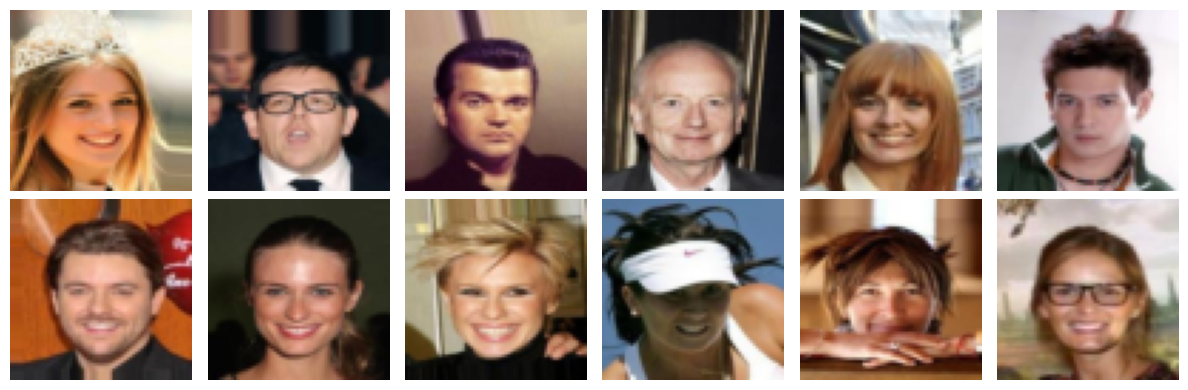

In [15]:
# input samples 
plot_random_images(train_dataloader, num_images=12)

### 🚀 Model Training Configuration and Execution

Sets up the training configuration for the Variational Autoencoder by defining the number of epochs, reconstruction loss function, optimizer, and learning rate scheduler. The training loop is then executed with validation enabled, allowing periodic visualization of reconstructions and automatic learning rate adjustment based on validation loss. Training metrics are collected and returned for later analysis. We use mean squared error as loss function and note that the loss is used as sum not mean. The mean makes the loss very small and iterations doesnt improves the model.

In [11]:
NUM_EPOCHS = 2

loss_func = nn.MSELoss(reduction='sum') 
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1)

results = train_loop(model, 
                     loss_func,
                     train_loader=train_dataloader,
                     chkpoint_dir=CHKPOINT_DIR,
                     val_loader=test_dataloader,
                     optimizer=optimizer,
                     lr_schedule=scheduler,
                     device=DEVICE,
                     epochs=NUM_EPOCHS, plot_cases_val=True)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 0 time: 3.05 sec
Train Loss:        118051.58


Validation at epoch 0: images saved.


Epoch:  50%|█████     | 1/2 [00:04<00:04,  4.47s/it]

Epoch 1 time: 2.35 sec
Train Loss:        48008.06


Validation at epoch 1: images saved.


Epoch: 100%|██████████| 2/2 [00:08<00:00,  4.23s/it]


### 📈 Visualizing Training Dynamics

Plots the evolution of total loss (as the summation of the Reconstruction loss and KL loss), reconstruction loss, and KL divergence loss across training epochs for both training and validation sets. These learning curves provide insight into convergence behavior, reconstruction quality, and latent space regularization, helping to diagnose underfitting, overfitting, or imbalance between reconstruction and KL terms during VAE training.

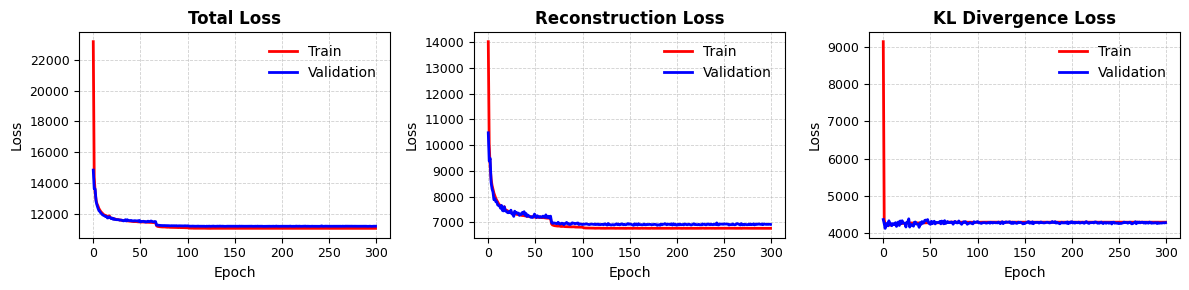

In [6]:
plot_learning_curves(results)

### 🔍 Inference and Latent Space Sampling

Moves the trained model to the CPU and defines helper functions for inference and sample generation. A random image is selected from the dataset, encoded into its latent mean and variance, and reconstructed through the decoder. New samples are then generated by sampling multiple latent vectors using the reparameterization trick and decoding them, enabling qualitative exploration of the learned latent space and the model’s generative capability.

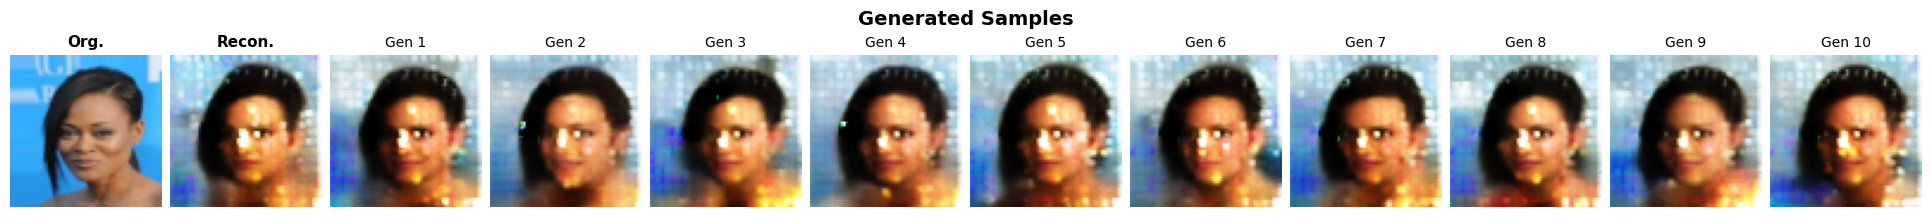

In [17]:
model = model.to('cpu')
plot_generated_test_samples(model, test_dataset, n_examples=10)

© Ashkan M., NTNU  
Released under the MIT License